In [690]:
import abc
from collections import defaultdict, namedtuple
from copy import deepcopy
from dataclasses import dataclass, field
from enum import IntEnum
from typing import MutableSequence
from typing import Optional, Iterator, Sequence, TypeVar, Set, Mapping, Union, Tuple, Iterable, FrozenSet

import clingo
import clingraph
from clingraph import Factbase, compute_graphs
from more_itertools import powerset


In [691]:
def asp_solve(programs,
              ctl: Optional[clingo.Control] = None,
              parts=(('base', ()),),
              context=None,
              report=False,
              report_models=True,
              report_result=True,
              symbol_sep=' ',
              model_sep='\n'
              ) -> Iterator[Sequence[clingo.Symbol]]:
    if ctl is None:
        ctl = clingo.Control(logger=lambda *args, **kwargs: None)
        ctl.configuration.solve.models = 0
    ctl.add('base', [], '\n'.join(programs))
    ctl.ground(parts, context=context)
    with ctl.solve(yield_=True) as solve_handle:
        models = 0
        for model in solve_handle:
            symbols = sorted(model.symbols(shown=True))
            if report and report_models:
                print("Answer {}:".format(model.number), end=' ')
                print("{",
                      symbol_sep.join(map(str, symbols)), "}", sep=symbol_sep, end=model_sep)
            models += 1
            yield symbols
        if report and report_result:
            solve_result = solve_handle.get()
            print(solve_result, end='')
            if solve_result.satisfiable:
                print(" {}{}".format(models, '' if solve_result.exhausted else '+'))
            else:
                print()


def draw_graph(programs,
               ctl: Optional[clingo.Control] = None,
               parts=(('base', ()),)):
    fb = Factbase()
    if ctl is None:
        ctl = clingo.Control(logger=lambda *args, **kwargs: None)
        ctl.configuration.solve.models = 0
    ctl.add('base', [], '\n'.join(programs))
    ctl.ground(parts, clingraph.clingo_utils.ClingraphContext())
    with ctl.solve(yield_=True) as solve_handle:
        for model in solve_handle:
            fb.add_model(model)
            break
    return compute_graphs(fb)

In [692]:
ForwardASPSymbol = TypeVar('ForwardASPSymbol', bound='ASPSymbol')
ForwardASPVariable = TypeVar('ForwardASPVariable', bound='ASPVariable')


class ASPSymbol(abc.ABC):

    @staticmethod
    def from_clingo_symbol(symbol: clingo.Symbol) -> ForwardASPSymbol:
        if symbol.type is clingo.SymbolType.Number:
            return ASPTerm(ASPIntegerConstant(symbol.number))
        elif symbol.type is clingo.SymbolType.String:
            return ASPTerm(ASPStringConstant(symbol.string))
        elif symbol.type is clingo.SymbolType.Function:
            arguments = tuple(ASPFunction.from_clingo_symbol(argument) for argument in symbol.arguments)
            name = symbol.name
            if symbol.negative:
                name = "-{}".format(name)
            return ASPFunction(name, arguments)
        else:
            assert False, "Unhandled clingo.Symbol {} with type {}.".format(symbol, symbol.type.name)


@dataclass(order=True, frozen=True)
class ASPStringConstant:
    string: str = field(default="")

    def __str__(self):
        return '"{}"'.format(self.string)


@dataclass(order=True, frozen=True)
class ASPIntegerConstant:
    number: int = field(default=0)

    def __str__(self):
        return str(self.number)


@dataclass(order=True, frozen=True)
class ASPTerm(ASPSymbol):
    constant: Union[ASPStringConstant, ASPIntegerConstant] = field(default_factory=ASPIntegerConstant)

    def __str__(self):
        return str(self.constant)

    @staticmethod
    def zero():
        return ASPTerm(ASPIntegerConstant(0))

    @staticmethod
    def one():
        return ASPTerm(ASPIntegerConstant(1))


ForwardASPTopLevelSymbol = TypeVar('ForwardASPTopLevelSymbol', bound='ASPTopLevelSymbol')


class ASPTopLevelSymbol(ASPSymbol, abc.ABC):

    @property
    def signature(self) -> str:
        return "{}/{}.".format(self.function_name, self.arity)

    @property
    @abc.abstractmethod
    def function_name(self) -> str:
        raise NotImplementedError

    @property
    def arity(self) -> int:
        return len(self.function_arguments)

    @property
    @abc.abstractmethod
    def function_arguments(self) -> Sequence[ASPSymbol]:
        raise NotImplementedError

    def match(self, other: ForwardASPTopLevelSymbol) -> bool:
        return self.function_name == other.function_name and len(self.function_arguments) == len(
            other.function_arguments)


def asp_evaluate(*programs, report=False) -> Iterator[FrozenSet[ASPTopLevelSymbol]]:
    for answer_set in asp_solve(programs=programs, report=report):
        yield frozenset(ASPFunction.from_clingo_symbol(symbol) for symbol in answer_set)


@dataclass(order=True, frozen=True)
class ASPFunction(ASPTopLevelSymbol):
    name: Optional[str] = field(default=None)
    arguments: Sequence[ASPSymbol] = field(default_factory=tuple)

    @property
    def function_name(self) -> str:
        return self.name

    @property
    def function_arguments(self) -> Sequence[ASPSymbol]:
        return self.arguments

    @property
    def arity(self) -> int:
        return len(self.arguments)

    def __str__(self):
        if self.name is None:
            return '({})'.format(','.join(map(str, self.arguments)))
        elif not self.arguments:
            return self.name
        else:
            return '{}({})'.format(self.name, ','.join(map(str, self.arguments)))


ForwardASPAtom = TypeVar('ForwardASPAtom', bound='ASPAtom')


@dataclass(order=True, frozen=True)
class ASPAtom:
    symbol: ASPTopLevelSymbol = field(default_factory=ASPFunction)

    @property
    def signature(self) -> str:
        return self.symbol.signature

    def match(self, other: ForwardASPAtom) -> bool:
        return self.symbol.function_name == other.symbol.function_name and len(self.symbol.function_arguments) == len(
            other.symbol.function_arguments)

    def __str__(self):
        return str(self.symbol)


@dataclass(order=True, frozen=True)
class ASPClauseElement(abc.ABC):

    @property
    @abc.abstractmethod
    def signature(self) -> str:
        raise NotImplementedError

    @property
    @abc.abstractmethod
    def is_pos(self):
        raise NotImplementedError

    @property
    @abc.abstractmethod
    def is_neg(self):
        raise NotImplementedError

    def __neg__(self):
        raise NotImplementedError

    def __abs__(self):
        raise NotImplementedError


class ASPHeadClauseElement(ASPClauseElement):
    pass


class ASPLiteral(ASPHeadClauseElement):

    @property
    @abc.abstractmethod
    def signature(self) -> str:
        raise NotImplementedError

    @property
    @abc.abstractmethod
    def is_pos(self) -> bool:
        raise NotImplementedError

    @property
    @abc.abstractmethod
    def is_neg(self) -> bool:
        raise NotImplementedError


class ASPSign(IntEnum):
    NoSign = 0
    Negation = 1

    def __str__(self):
        if self is ASPSign.NoSign:
            return ''
        elif self is ASPSign.Negation:
            return 'not'
        else:
            assert False, 'Unknown IntEnum {} = {}.'.format(self.name, self.value)


@dataclass(order=True, frozen=True)
class ASPBasicLiteral(ASPLiteral):
    sign: ASPSign = ASPSign.NoSign
    atom: ASPAtom = field(default_factory=ASPAtom)

    @property
    def is_pos(self) -> bool:
        return self.sign is ASPSign.NoSign

    @property
    def is_neg(self) -> bool:
        return self.sign is ASPSign.Negation

    @property
    def signature(self) -> str:
        return self.atom.signature

    def __str__(self):
        if self.sign is ASPSign.NoSign:
            return "{}".format(self.atom)
        else:
            return "{} {}".format(self.sign, self.atom)

    def __neg__(self):
        return ASPBasicLiteral(ASPSign((self.sign ^ 1) % 2), self.atom)

    def __abs__(self):
        return ASPBasicLiteral(ASPSign.NoSign, self.atom)

    def as_classical_atom(self):
        return ClassicalAtom(str(self.atom.symbol))

    @staticmethod
    def make_literal(name: Optional[str], *arguments: Union[str, int, ASPFunction]):
        function_arguments = []
        for arg_ in arguments:
            if isinstance(arg_, str):
                arg = ASPFunction(arg_)
            elif isinstance(arg_, int):
                arg = ASPTerm(ASPIntegerConstant(arg_))
            else:
                arg = arg_
            function_arguments.append(arg)
        return ASPBasicLiteral(atom=ASPAtom(ASPFunction(name=name, arguments=tuple(function_arguments))))


@dataclass(order=True, frozen=True)
class ASPRule(abc.ABC):
    head: Optional[ASPHeadClauseElement] = field(default=None)
    body: Optional[Sequence[ASPClauseElement]] = field(default=None)

    @property
    @abc.abstractmethod
    def head_signature(self) -> str:
        raise NotImplementedError

    @staticmethod
    def fmt_body(body: Sequence[ASPClauseElement]):
        return ', '.join(map(str, body))


@dataclass(order=True, frozen=True)
class ASPNormalRule(ASPRule):
    head: ASPBasicLiteral = field(default_factory=ASPBasicLiteral)
    body: Sequence[ASPClauseElement] = field(default_factory=tuple)

    @property
    def head_signature(self) -> str:
        return self.head.signature

    def __str__(self):
        if self.body:
            return "{} :- {}.".format(self.head, ASPRule.fmt_body(self.body))
        else:
            return "{}.".format(self.head)


@dataclass(order=True, frozen=True)
class ASPIntegrityConstraint(ASPRule):
    body: Sequence[ASPClauseElement] = field(default_factory=tuple)
    head: bool = field(default=False, init=False)

    @property
    def head_signature(self) -> str:
        return '#false/0.'

    def __str__(self):
        if self.body:
            return ":- {}.".format(ASPRule.fmt_body(self.body))
        else:
            return ":-."


@dataclass(frozen=True, order=True)
class ClassicalAtom:
    symbol: str

    @property
    def is_complement(self) -> bool:
        return self.symbol.startswith('-')

    def __neg__(self):
        if self.is_complement:
            return ClassicalAtom(self.symbol[1:])
        else:
            return ClassicalAtom('-{}'.format(self.symbol))

    def __abs__(self):
        if self.is_complement:
            return -self
        return self

    def __str__(self):
        return self.symbol


ClassicalAlphabet = Set[ClassicalAtom]
ClassicalValuation = Mapping[ClassicalAtom, bool]


@dataclass(frozen=True, order=True)
class ClassicalLiteral:
    atom: ClassicalAtom
    sign: bool = field(default=True)

    def __str__(self):
        sign_str = ""
        if not self.sign:
            sign_str = "¬"
        return "{}{}".format(sign_str, self.atom)

    def __repr__(self):
        return str(self)

    def __neg__(self):
        return ClassicalLiteral(self.atom, not self.sign)

    def __and__(self, other):
        left = ClassicalFormula(self)
        right = other
        if isinstance(other, ClassicalLiteral):
            right = ClassicalFormula(right)
        return ClassicalFormula(left, ClassicalConnective.And, right)

    def __or__(self, other):
        left = ClassicalFormula(self)
        right = other
        if isinstance(other, ClassicalLiteral):
            right = ClassicalFormula(right)
        return ClassicalFormula(left, ClassicalConnective.Or, right)

    def __rshift__(self, other):
        left = ClassicalFormula(self)
        right = other
        if isinstance(other, ClassicalLiteral):
            right = ClassicalFormula(right)
        return ClassicalFormula(left, ClassicalConnective.Implies, right)


@dataclass(frozen=True, order=True)
class ClassicalTop(ClassicalLiteral):
    atom: ClassicalAtom = field(default=ClassicalAtom('⊤'), init=False)
    sign: bool = field(default=True, init=False)

    def __str__(self):
        return str(self.atom)

    def __repr__(self):
        return str(self)

    def __neg__(self):
        return ClassicalBot()

    def __and__(self, other):
        if isinstance(other, ClassicalLiteral):
            return ClassicalFormula(other)
        return other

    def __or__(self, other):
        return ClassicalFormula(ClassicalTop())


@dataclass(frozen=True, order=True)
class ClassicalBot(ClassicalLiteral):
    atom: ClassicalAtom = field(default=ClassicalAtom('⊥'), init=False)
    sign: bool = field(default=False, init=False)

    def __neg__(self):
        return ClassicalTop()

    def __str__(self):
        return str(self.atom)

    def __and__(self, other):
        return ClassicalFormula(ClassicalBot())

    def __or__(self, other):
        if isinstance(other, ClassicalLiteral):
            return ClassicalFormula(other)
        return other


class ClassicalConnective(IntEnum):
    And = 0
    Or = 1
    Implies = 2

    def __str__(self):
        if self is ClassicalConnective.And:
            return "∧"
        elif self is ClassicalConnective.Or:
            return "∨"
        elif self is ClassicalConnective.Implies:
            return "→"
        else:
            assert False, "Unhandled Connective.__str__: {} = {}".format(self.name, self.value)

    def evaluate(self, left: bool, right: bool):
        if self is ClassicalConnective.And:
            return left and right
        elif self is ClassicalConnective.Or:
            return left or right
        elif self is ClassicalConnective.Implies:
            return not left or right
        else:
            assert False, "Unhandled Connective.evaluate: {} = {}".format(self.name, self.value)


ForwardClassicalFormula = TypeVar('ForwardClassicalFormula', bound='ClassicalFormula')


@dataclass(frozen=True, order=True)
class ClassicalFormula:
    left: Union[ForwardClassicalFormula, ClassicalLiteral]
    connective: Optional[ClassicalConnective] = field(default=None)
    right: Union[ForwardClassicalFormula, None] = field(default=None)

    def __str__(self):
        left_str = str(self.left)
        connective_str = ""
        if self.connective is not None:
            connective_str = " {}".format(self.connective)
            if isinstance(self.left,
                          ClassicalFormula) and self.left.connective is not None and self.left.connective > self.connective:
                left_str = "({})".format(left_str)
        right_str = ""
        if self.right is not None:
            if self.right.left == ClassicalBot() and self.right.right is None:
                left_str = "¬({})".format(left_str)
                connective_str = ""
            else:
                right_str = " {}".format(self.right)
            if isinstance(self.right,
                          ClassicalFormula) and self.right.connective is not None and self.right.connective > self.connective:
                left_str = "({})".format(left_str)
        return "{}{}{}".format(left_str, connective_str, right_str)

    def __repr__(self):
        return str(self)

    def evaluate(self, valuation: Optional[ClassicalValuation] = None) -> bool:
        if isinstance(self.left, ClassicalLiteral):
            value_left = self.__evaluate_literal(self.left, valuation)
        else:
            assert isinstance(self.left, ClassicalFormula), "Unknown type for Formula.left. {}: {}".format(
                type(self.left).__name__, self.left)
            value_left = self.left.evaluate(valuation)
        if self.connective is not None and self.right is None:
            raise TypeError("Formula.connective present, despite Formula.right missing.")
        elif self.connective is None and self.right is not None:
            raise TypeError("Formula.connective missing, despite Formula.right present.")

        if self.connective is None and self.right is None:
            return value_left
        else:
            assert isinstance(self.right, ClassicalFormula), "Unknown type for Formula.right. {}: {}".format(
                type(self.right).__name__, self.right)
            value_right = self.right.evaluate(valuation)

            return self.connective.evaluate(value_left, value_right)

    def __evaluate_literal(self, literal: ClassicalLiteral, valuation: Optional[ClassicalValuation] = None) -> bool:
        if isinstance(literal, ClassicalTop) or isinstance(literal, ClassicalBot):
            return literal.sign
        else:
            # get assigned truth value of atom (per default false) and flip the result if negated
            return valuation is not None and bool(valuation.get(literal.atom, False) ^ (not literal.sign))

    @property
    def literals(self) -> Set[ClassicalLiteral]:
        literals = set()
        if isinstance(self.left, ClassicalLiteral):
            if not isinstance(self.left, ClassicalTop) and not isinstance(self.left, ClassicalBot):
                literals.add(self.left)
        else:
            assert isinstance(self.left, ClassicalFormula), "Unknown type for Formula.right. {}: {}".format(
                type(self.left).__name__, self.left)
            literals.update(self.left.literals)
        if self.right is not None:
            assert isinstance(self.right, ClassicalFormula), "Unknown type for Formula.right. {}: {}".format(
                type(self.right).__name__, self.right)
            literals.update(self.right.literals)
        return literals

    @property
    def atoms(self) -> Set[ClassicalAtom]:
        return {literal.atom for literal in self.literals}

    def __neg__(self):
        if self.connective is not None and self.right is None:
            raise TypeError("Formula.connective present, despite Formula.right missing.")
        elif self.connective is None and self.right is not None:
            raise TypeError("Formula.connective missing, despite Formula.right present.")

        if self.connective is None and self.right is None:
            return ClassicalFormula(-self.left)
        elif self.connective is ClassicalConnective.And:
            return ClassicalFormula(-self.left, ClassicalConnective.Or, -self.right)
        elif self.connective is ClassicalConnective.Or:
            return ClassicalFormula(-self.left, ClassicalConnective.And, -self.right)
        elif self.connective is ClassicalConnective.Implies:
            if self.right.left == ClassicalBot() and self.right.right is None:
                return self.left
            return ClassicalFormula(self, ClassicalConnective.Implies, ClassicalFormula(ClassicalBot()))
        else:
            assert False, "Unknown Formula.connective. {} = {}.".format(self.connective.name, self.connective.value)

    @property
    def is_top(self) -> bool:
        return self.right is None and isinstance(self.left, ClassicalTop)

    @property
    def is_bot(self) -> bool:
        return self.right is None and isinstance(self.left, ClassicalBot)

    def __and__(self, other):
        left = self
        right = other
        if isinstance(other, ClassicalLiteral):
            right = ClassicalFormula(right)
        if left.is_top:
            return right
        elif right.is_top:
            return left
        if left.is_bot:
            return left
        elif right.is_bot:
            return right
        return ClassicalFormula(left, ClassicalConnective.And, right)

    def __or__(self, other):
        left = self
        right = other
        if isinstance(other, ClassicalLiteral):
            right = ClassicalFormula(right)
        if left.is_top:
            return left
        elif right.is_top:
            return right
        if left.is_bot:
            return right
        elif right.is_bot:
            return left
        return ClassicalFormula(left, ClassicalConnective.Or, right)

    def __rshift__(self, other):
        left = self
        right = other
        if isinstance(other, ClassicalLiteral):
            right = ClassicalFormula(right)
        return ClassicalFormula(left, ClassicalConnective.Implies, right)

    def __call__(self, valuation: Optional[ClassicalValuation] = None) -> bool:
        return self.evaluate(valuation)


def all_valuations(alphabet: ClassicalAlphabet, complete: bool = False) -> Iterator[ClassicalValuation]:
    subsets = powerset(alphabet)
    for subset in subsets:
        valuation = defaultdict(lambda: False)
        for atom in subset:
            valuation[atom] = True
        if complete:
            for atom in alphabet:
                if atom not in subset:
                    valuation[atom] = False
        yield valuation


def models(formulas: Set[ClassicalFormula], alphabet: Optional[ClassicalAlphabet] = None) -> Iterator[
    ClassicalValuation]:
    if alphabet is None:
        alphabet = {atom for formula in formulas for atom in formula.atoms}
    for valuation in all_valuations(alphabet):
        if all(formula.evaluate(valuation) for formula in formulas):
            yield valuation


def sat(formulas: Set[ClassicalFormula], alphabet: Optional[ClassicalAlphabet] = None) -> bool:
    model = next(models(formulas, alphabet), None)
    return model is not None


def unsat(formulas: Set[ClassicalFormula], alphabet: Optional[ClassicalAlphabet] = None) -> bool:
    return not sat(formulas, alphabet)


def entails(formulas: Set[ClassicalFormula], formula: ClassicalFormula) -> bool:
    return unsat(formulas | {-formula})


def valid(formulas: Set[ClassicalFormula], alphabet: Optional[ClassicalAlphabet] = None) -> bool:
    if alphabet is None:
        alphabet = {atom for formula in formulas for atom in formula.atoms}
    for valuation in all_valuations(alphabet):
        if any(not formula.evaluate(valuation) for formula in formulas):
            return False
    return True


def empty_conditions(*args, **kwargs):
    return defaultdict(lambda: ClassicalFormula(ClassicalBot()))


@dataclass
class ADF:
    statements: Set[ClassicalAtom] = field(default_factory=set)
    conditions: Mapping[ClassicalAtom, ClassicalFormula] = field(default_factory=empty_conditions)
    rule_atoms: Set[ClassicalAtom] = field(default_factory=set)

    def is_fact(self, atom: ClassicalAtom) -> bool:
        return atom in self.conditions and any(
            condition in self.conditions and self.conditions[condition].is_top for condition in
            self.conditions[atom].atoms)

    def is_non_factual(self, atom: ClassicalAtom) -> bool:
        return self.conditions.get(atom, ClassicalFormula(ClassicalBot())).is_bot

    def __str__(self):
        return "{}{}{} <{}>".format('{', ' '.join(map(str, self.statements)), '}',
                                    ', '.join(map(lambda i: '{}: {}'.format(i[0], i[1]), self.conditions.items())))

    def __repr__(self):
        return str(self)


def asp_to_adf(*rules: ASPRule):
    statements = set()
    conditions = empty_conditions()
    rule_atoms = set()
    for i, rule in enumerate(rules):
        r = ClassicalLiteral(ClassicalAtom('r{}'.format(i + 1)))
        rule_atoms.add(r.atom)
        bs = set(
            ClassicalLiteral(ClassicalAtom(str(literal.atom.symbol)), sign=literal.is_pos) for literal in rule.body)
        statements.add(r.atom)
        statements.update(b.atom for b in bs)
        if isinstance(rule, ASPNormalRule):
            h = ClassicalLiteral(ClassicalAtom(str(rule.head.atom.symbol)))
            statements.add(h.atom)

            formula = conditions[h.atom]
            formula = formula | r
            conditions[h.atom] = formula
            formula = ClassicalFormula(ClassicalTop())

        elif isinstance(rule, ASPIntegrityConstraint):
            formula = -ClassicalFormula(r)
        else:
            assert False, "Unknown ASPRule {} with type {}.".format(rule, type(rule).__name__)

        for b in bs:
            formula = formula & b
        conditions[r.atom] = formula

    complements = set()
    for complement in statements:
        if complement.is_complement:
            for statement in statements:
                if statement == -complement:
                    cmp = ClassicalLiteral(ClassicalAtom('cmp({})'.format(statement.symbol)))
                    cmp_condition = -cmp & ClassicalLiteral(statement) & ClassicalLiteral(complement)
                    complements.add(cmp.atom)
                    conditions[cmp.atom] = cmp_condition

    statements.update(complements)

    return ADF(statements, conditions, rule_atoms)


def answer_set_to_valuation(answer_set: Iterable[ASPTopLevelSymbol]) -> ClassicalValuation:
    valuation = defaultdict(lambda: False)
    for elem in answer_set:
        atom = ClassicalAtom(str(elem))
        valuation[atom] = True
    return valuation


def valuation_to_extension(valuation: ClassicalValuation) -> Set[ClassicalAtom]:
    extension = set()
    for atom, truthvalue in valuation.items():
        if truthvalue:
            extension.add(atom)
    return extension


def extension_to_valuation(extension: Set[ClassicalAtom]) -> ClassicalValuation:
    valuation = defaultdict(lambda: False)
    for atom in extension:
        valuation[atom] = True
    return valuation

In [693]:
PDE = Tuple[ClassicalAtom, Set[ClassicalAtom], Set[ClassicalAtom], Sequence[ClassicalAtom]]


def fmt_pde(pde: PDE) -> str:
    return "({}, {}{}{}, {}{}{}, [{}])".format(pde[0], '{', ','.join(map(str, pde[1])), '}', '{',
                                               ','.join(map(str, pde[2])), '}', ','.join(map(str, pde[3])))


def print_pde(pde: PDE):
    print(fmt_pde(pde))


def get_pdes(adf: ADF,
             e: ClassicalAtom,
             extension: Set[ClassicalAtom],
             sequence: Optional[MutableSequence[ClassicalAtom]] = None,
             facts: Optional[Set[ClassicalAtom]] = None,
             blocking: Optional[Set[ClassicalAtom]] = None) -> Sequence[PDE]:
    if facts is None:
        facts = set()
    if blocking is None:
        blocking = set()
    if sequence is None:
        sequence = []

    sequence.insert(0, e)

    conditions = set(adf.conditions[e].atoms)

    pdes = []

    for condition in conditions:
        if len(conditions) > 1:
            facts_ = deepcopy(facts)
            blocking_ = deepcopy(blocking)
            sequence_ = deepcopy(sequence)
        else:
            facts_ = facts
            blocking_ = blocking
            sequence_ = sequence
        sequence_.insert(0, condition)
        if adf.is_fact(e):
            facts_.add(e)
            pdes.append((e, facts_, blocking_, sequence_))
            return pdes

        subcondition = adf.conditions[condition]
        literals = set(subcondition.literals)
        branch_pdes = [(e, facts_, blocking_, sequence_)]
        subpdes = None
        for literal in literals:
            if literal.sign is False:
                blocking_.add(literal.atom)
                continue
            subpdes = []
            for branch in branch_pdes:
                _, facts_, blocking_, sequence_ = branch
                subpdes.extend(get_pdes(adf, literal.atom, extension, sequence_, facts_, blocking_))
            branch_pdes = subpdes
        if subpdes is not None and subpdes:
            for subpde in subpdes:
                _, facts_, blocking_, sequence_ = subpde
                pdes.append((e, facts_, blocking_, sequence_))
        else:
            pdes.append((e, facts_, blocking_, sequence_))

    return pdes


In [694]:
CompactPDE = Tuple[ClassicalAtom, FrozenSet[ClassicalAtom], FrozenSet[ClassicalAtom], FrozenSet[ClassicalAtom]]


def fmt_compact_pde(pde: CompactPDE) -> str:
    return "({}, {}{}{}, {}{}{}, {}{}{})".format(pde[0], '{', ','.join(map(str, sorted(pde[1]))), '}', '{',
                                                 ','.join(map(str, sorted(pde[2]))), '}', '{',
                                                 ','.join(map(str, sorted(pde[3]))), '}')


def print_compact_pde(pde: CompactPDE):
    print(fmt_compact_pde(pde))


ForwardASLExplanationGraph = TypeVar('ForwardASLExplanationGraph', bound='ASLExplanationGraph')


@dataclass
class ASLJustificationTree:
    adf: ADF
    extension: Set[ClassicalAtom]
    pde: CompactPDE
    proof: bool = field(default=False)
    children: Optional[MutableSequence[ForwardASLExplanationGraph]] = field(default=None)

    @property
    def is_expanded(self) -> bool:
        return self.children is not None

    def expand(self):
        raise NotImplementedError

    def expand_recursively(self, depth=None):
        if depth is not None and depth <= 0:
            return
        self.expand()
        for child in self.children:
            child.expand_recursively(depth=None if depth is None else depth - 1)

    def fmt(self, indent=0, root=True):
        fmt = ""
        if root:
            fmt += '*\n|'
        for i in range(indent):
            fmt += '|  '
        if indent > 0:
            fmt += '\n'
            for i in range(indent - 1):
                fmt += '|  '
            fmt += '|__'

        fmt += '__' + str(self)
        if self.is_expanded:
            for child in self.children:
                fmt += '\n' + child.fmt(indent=indent + 1, root=False)
        return fmt

    def pretty_print(self):
        print(self.fmt())

    def __str__(self):
        return "<{},{}>".format(fmt_compact_pde(self.pde), '+' if self.proof else '-')


@dataclass
class ASLRefutation(ASLJustificationTree):
    proof: bool = field(default=False, init=False)

    def expand(self):
        if self.is_expanded:
            return
        children = []

        for block in self.pde[2]:
            child_pdes = {compress(self.adf, pde) for pde in get_pdes(self.adf, block, self.extension)}
            assert len(child_pdes) == 1
            child = ASLProof(adf=self.adf,
                             extension=self.extension,
                             pde=compress(self.adf, next(iter(child_pdes))))
            children.append(child)
        self.children = children


@dataclass
class ASLProof(ASLJustificationTree):
    proof: bool = field(default=True, init=False)

    def expand(self, prefer: Optional[ClassicalAtom] = None):
        if self.is_expanded:
            return
        children = []

        if not self.adf.is_fact(self.pde[0]) and frozenset((-self.pde[0],)) != self.pde[2]:
            for block in self.pde[2]:
                if self.adf.is_non_factual(block):
                    continue
                child_pdes = {compress(self.adf, pde) for pde in get_pdes(self.adf, block, self.extension)}

                for pde in child_pdes:
                    child = ASLRefutation(adf=self.adf, extension=self.extension, pde=pde)
                    children.append(child)

        self.children = children


def compress(adf: ADF, pde: PDE) -> CompactPDE:
    literal, facts, blocking, sequence = pde
    return literal, frozenset(facts), frozenset(blocking), frozenset(
        elem for elem in sequence if elem in adf.rule_atoms)


def less_specific(pde1: CompactPDE, pde2: CompactPDE) -> bool:
    return pde1[0] == pde2[0] and (
            (pde1[1] >= pde2[1] and pde1[2] > pde2[2]) or (pde1[1] > pde2[1] and pde1[2] >= pde2[2]))


def more_specific(pde1: CompactPDE, pde2: CompactPDE) -> bool:
    return pde1[0] == pde2[0] and (
            (pde1[1] <= pde2[1] and pde1[2] < pde2[2]) or (pde1[1] < pde2[1] and pde1[2] <= pde2[2]))


def compare_cde(pde1: CompactPDE, pde2: CompactPDE) -> int:
    if less_specific(pde1, pde2) and more_specific(pde2, pde1):
        return -1
    elif less_specific(pde2, pde1) and more_specific(pde1, pde2):
        return 1
    else:
        return 0


def make_program(*rules: ASPRule):
    return '\n'.join(map(str, rules))

In [695]:
BPDE = namedtuple('BPDE', ['atom', 'facts', 'blocking', 'unfounded', 'sequence'])


def fmt_bpde(bpde: BPDE):
    return "({},{}{}{},{}{}{},{}{}{},[{}])".format(bpde.atom,
                                                   '{',
                                                   ','.join(map(str, bpde.facts)),
                                                   '}',
                                                   '{',
                                                   ','.join(map(str, bpde.blocking)),
                                                   '}',
                                                   '{',
                                                   ','.join(map(str, bpde.unfounded)),
                                                   '}',
                                                   ','.join(map(str, bpde.sequence))
                                                   )


def print_bpde(bpde: BPDE):
    print(fmt_bpde(bpde))

In [696]:
def backwards_pde(adf: ADF,
                  query: ClassicalAtom,
                  facts: Optional[Set[ClassicalAtom]] = None,
                  blocking: Optional[Set[ClassicalAtom]] = None,
                  unfounded: Optional[Set[ClassicalAtom]] = None,
                  sequence: Optional[MutableSequence[ClassicalAtom]] = None
                  ) -> Sequence[BPDE]:
    if facts is None:
        facts = set()
    if blocking is None:
        blocking = set()
    if unfounded is None:
        unfounded = set()
    if sequence is None:
        sequence = list()

    sequence.insert(0, query)

    if query in facts:
        return [BPDE(query, facts, blocking, unfounded, sequence)]

    unfounded.add(query)

    condition_formula = adf.conditions[query]
    conditions = set(condition_formula.atoms)

    pdes = []

    for condition in conditions:
        if len(conditions) > 1:
            facts_ = deepcopy(facts)
            blocking_ = deepcopy(blocking)
            unfounded_ = deepcopy(unfounded)
            sequence_ = deepcopy(sequence)
        else:
            facts_ = facts
            blocking_ = blocking
            unfounded_ = unfounded
            sequence_ = sequence

        sequence_.insert(0, condition)

        if adf.is_fact(query):
            facts_.add(query)
            unfounded_.remove(query)
            pdes.append(BPDE(query, facts_, blocking_, unfounded_, sequence_))
        else:

            literals = set(adf.conditions[condition].literals)
            subpdes = None
            branch_pdes = [BPDE(query, facts_, blocking_, unfounded_, sequence_)]
            for literal in literals:
                if literal.sign is False:
                    blocking_.add(literal.atom)
                else:
                    if literal.atom in facts_ or literal.atom in unfounded_:
                        continue
                    subpdes = []
                    for branch in branch_pdes:
                        _, facts_, blocking_, unfounded_, sequence_ = branch
                        unfounded_.add(literal.atom)
                        subpdes_ = backwards_pde(adf, literal.atom, facts_, blocking_,
                                                 unfounded_, sequence_)
                        subpdes.extend(subpdes_)
            if subpdes is not None and subpdes:
                for subpde in subpdes:
                    _, facts_, blocking_, unfounded_, sequence_ = subpde
                    if {literal.atom for literal in adf.conditions[condition].literals if literal.sign}.isdisjoint(
                            unfounded_):
                        unfounded_.remove(query)
                    pdes.append(BPDE(query, facts_, blocking_, unfounded_, sequence_))
            else:
                pdes.append(BPDE(query, facts_, blocking_, unfounded_, sequence_))
        if query in unfounded_ and {literal.atom for literal in adf.conditions[condition].literals if
                                    literal.sign}.isdisjoint(unfounded_):
            unfounded_.remove(query)

    if not conditions:
        pdes = [BPDE(query, facts, blocking, unfounded, sequence)]

    return pdes


In [697]:
COMMON = """

node(U) :- edge((U,V)).
node(V) :- edge((U,V)).

attr(node, L, label, L) :- pos_atom(L).
attr(node, N, label, @concat("¬", P)) :- neg_atom(N), pos_neg(P,N).
attr(node, N, fontname, "fira-sans") :- node(N).
attr(edge, E, fontname, "fira-sans") :- edge(E).

attr(node, L, style, filled) :- neg_atom(L).
attr(node, L, fontcolor, white) :- neg_atom(L).
attr(node, L, color, black) :- neg_atom(L).

node(Rule) :- rule(Rule).
rule(R) :- fact(R).
%attr(node, R, width, L+1) :- rule(R), L = #count { F : edge((R, F)) }.

attr(edge, E, dir, forward) :- edge(E).
attr(edge, E, style, dashed) :- neg_edge(E).
attr(node, Rule, shape, box) :- rule(Rule).
attr(node, Elem, style, dashed) :- unfounded(Elem).

pos_atom(P) :- pos_neg(P, N).
neg_atom(N) :- pos_neg(P, N).

edge(E) :- neg_edge(E).
edge(E) :- pos_edge(E).

"""

In [698]:
def pde_to_clingraph_prg(adf:ADF, pde: PDE):
    prg = ""
    for elem in pde[3]:
        prg += "node({}).".format(elem)
        if elem.is_complement:
            prg += "neg_atom({}).".format(elem)
        else:
            prg += "pos_atom({}).".format(elem)
        if -elem in adf.statements:
            prg += "pos_neg({},{}).".format(abs(elem), -abs(elem))
        if elem in adf.rule_atoms:
            prg += "rule({}).".format(elem)

        for literal in adf.conditions[elem].literals:
            if literal.atom.is_complement:
                prg += "neg_atom({}).".format(literal.atom)
            else:
                prg += "pos_atom({}).".format(literal.atom)
            if -literal.atom in adf.statements:
                prg += "pos_neg({},{}).".format(abs(literal.atom), -abs(literal.atom))
            if literal.sign:
                prg += "pos_edge(({},{})).".format(literal.atom, elem)
            else:
                prg += "neg_edge(({},{})).".format(literal.atom, elem)

    return prg

In [699]:
b = ASPBasicLiteral.make_literal('b')  # she has a book to finish working through
w = ASPBasicLiteral.make_literal('w')  # she will work late
o = ASPBasicLiteral.make_literal('o')  # the library will be open when she arrives
p = ASPBasicLiteral.make_literal('p')  # there is a party she would rather go to

r1 = ASPNormalRule(w, (b, o, -p))
r2 = ASPNormalRule(b)
r3 = ASPNormalRule(o)

rs = (r1, r2, r3)

prg = '\n'.join(map(str, rs))

print(prg)

w :- b, o, not p.
b.
o.


In [700]:
answer_sets = tuple(asp_evaluate(prg, report=True))
answer_set = answer_sets[0]

Answer 1: { b o w }
SAT 1


In [701]:
adf = asp_to_adf(*rs)
print(adf)

{w r1 p b o r2 r3} <w: r1, r1: b ∧ ¬p ∧ o, b: r2, r2: ⊤, o: r3, r3: ⊤>


In [702]:
bpdes = backwards_pde(adf, w.as_classical_atom())
for bpde in bpdes:
    print_bpde(bpde)

(w,{o,b},{p},{},[r3,o,r2,b,r1,w])


1


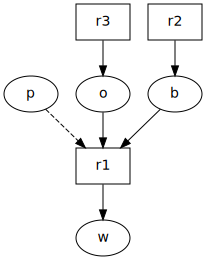

In [703]:
graphs = []
for bpde in bpdes:
    pde = (bpde.atom, bpde.facts, bpde.blocking, bpde.sequence)
    graph_prg = pde_to_clingraph_prg(adf, pde)
    graphs.append(draw_graph([graph_prg, COMMON])['default'])
print(len(graphs))
graphs[0]

In [704]:
bpdes = backwards_pde(adf, p.as_classical_atom())
for bpde in bpdes:
    print_bpde(bpde)

(p,{},{},{p},[p])


1


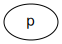

In [705]:
graphs = []
for bpde in bpdes:
    pde = (bpde.atom, bpde.facts, bpde.blocking, bpde.sequence)
    graph_prg = pde_to_clingraph_prg(adf, pde)
    graphs.append(draw_graph([graph_prg, COMMON])['default'])
print(len(graphs))
graphs[0]

In [706]:
bpdes = backwards_pde(adf, o.as_classical_atom())
for bpde in bpdes:
    print_bpde(bpde)

(o,{o},{},{},[r3,o])


1


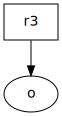

In [707]:
graphs = []
for bpde in bpdes:
    pde = (bpde.atom, bpde.facts, bpde.blocking, bpde.sequence)
    graph_prg = pde_to_clingraph_prg(adf, pde)
    graphs.append(draw_graph([graph_prg, COMMON])['default'])
print(len(graphs))
graphs[0]

In [708]:
a = ASPBasicLiteral.make_literal('a')
b = ASPBasicLiteral.make_literal('b')

r1 = ASPNormalRule(a, (-b,))
r2 = ASPNormalRule(b, (-a,))

rs = (r1, r2)

prg = make_program(*rs)
print(prg)

a :- not b.
b :- not a.


In [709]:
answer_sets = tuple(asp_evaluate(prg, report=True))

Answer 1: { b }
Answer 2: { a }
SAT 2


In [710]:
adf = asp_to_adf(*rs)
print(adf)

{r2 r1 b a} <a: r1, r1: ¬b, b: r2, r2: ¬a>


In [711]:
bpdes = backwards_pde(adf, a.as_classical_atom())
for bpde in bpdes:
    print_bpde(bpde)

(a,{},{b},{},[r1,a])


1


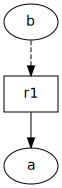

In [712]:
graphs = []
for bpde in bpdes:
    pde = (bpde.atom, bpde.facts, bpde.blocking, bpde.sequence)
    graph_prg = pde_to_clingraph_prg(adf, pde)
    graphs.append(draw_graph([graph_prg, COMMON])['default'])
print(len(graphs))
graphs[0]

In [713]:
bpdes = backwards_pde(adf, b.as_classical_atom())
for bpde in bpdes:
    print_bpde(bpde)

(b,{},{a},{},[r2,b])


In [714]:
a = ASPBasicLiteral.make_literal('a')
b = ASPBasicLiteral.make_literal('b')

r1 = ASPNormalRule(a, (-b,))
r2 = ASPNormalRule(b, (-a,))

rs = (r1, r2)

prg = make_program(*rs)
print(prg)

a :- not b.
b :- not a.


In [715]:
a = ASPBasicLiteral.make_literal('a')
b = ASPBasicLiteral.make_literal('b')
c = ASPBasicLiteral.make_literal('c')
e = ASPBasicLiteral.make_literal('e')
f = ASPBasicLiteral.make_literal('f')
k = ASPBasicLiteral.make_literal('k')

r1 = ASPNormalRule(a, (k, -b))
r2 = ASPNormalRule(k, (e, -b))
r3 = ASPNormalRule(c, (a, b))
r4 = ASPNormalRule(b, (-a,))
r5 = ASPNormalRule(c, (k,))
r6 = ASPNormalRule(f, (e, -k, -c))
r7 = ASPNormalRule(e)

rs = (r1, r2, r3, r4, r5, r6, r7)

prg = make_program(*rs)
print(prg)

a :- k, not b.
k :- e, not b.
c :- a, b.
b :- not a.
c :- k.
f :- e, not k, not c.
e.


In [716]:
answer_sets = tuple(asp_evaluate(prg, report=True))

Answer 1: { b e f }
Answer 2: { a c e k }
SAT 2


In [717]:
adf = asp_to_adf(*rs)
print(adf)

{r4 r5 r1 c k b r6 f r2 e r7 r3 a} <a: r1, r1: k ∧ ¬b, k: r2, r2: e ∧ ¬b, c: r3 ∨ r5, r3: b ∧ a, b: r4, r4: ¬a, r5: k, f: r6, r6: ¬k ∧ e ∧ ¬c, e: r7, r7: ⊤>


In [718]:
bpdes = backwards_pde(adf, f.as_classical_atom())
for bpde in bpdes:
    print_bpde(bpde)

(f,{e},{c,k},{},[r7,e,r6,f])


1


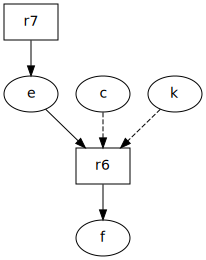

In [719]:
graphs = []
for bpde in bpdes:
    pde = (bpde.atom, bpde.facts, bpde.blocking, bpde.sequence)
    graph_prg = pde_to_clingraph_prg(adf, pde)
    graphs.append(draw_graph([graph_prg, COMMON])['default'])
print(len(graphs))
graphs[0]

In [720]:
bpdes = backwards_pde(adf, b.as_classical_atom())
for bpde in bpdes:
    print_bpde(bpde)

(b,{},{a},{},[r4,b])


1


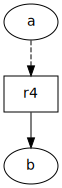

In [721]:
graphs = []
for bpde in bpdes:
    pde = (bpde.atom, bpde.facts, bpde.blocking, bpde.sequence)
    graph_prg = pde_to_clingraph_prg(adf, pde)
    graphs.append(draw_graph([graph_prg, COMMON])['default'])
print(len(graphs))
graphs[0]

In [722]:
bpdes = backwards_pde(adf, a.as_classical_atom())
for bpde in bpdes:
    print_bpde(bpde)

(a,{e},{b},{},[r7,e,r2,k,r1,a])


1


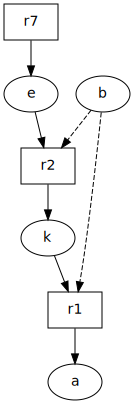

In [723]:
graphs = []
for bpde in bpdes:
    pde = (bpde.atom, bpde.facts, bpde.blocking, bpde.sequence)
    graph_prg = pde_to_clingraph_prg(adf, pde)
    graphs.append(draw_graph([graph_prg, COMMON])['default'])
print(len(graphs))
graphs[0]

In [724]:
bpdes = backwards_pde(adf, c.as_classical_atom())
for bpde in bpdes:
    print_bpde(bpde)

(c,{e},{b},{},[r7,e,r2,k,r5,c])
(c,{e},{b,a},{},[r7,e,r2,k,r1,a,r4,b,r3,c])


2


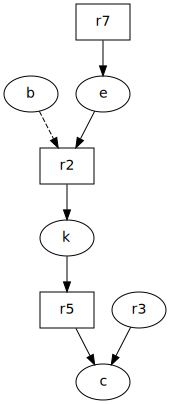

In [725]:
graphs = []
for bpde in bpdes:
    pde = (bpde.atom, bpde.facts, bpde.blocking, bpde.sequence)
    graph_prg = pde_to_clingraph_prg(adf, pde)
    graphs.append(draw_graph([graph_prg, COMMON])['default'])
print(len(graphs))
graphs[0]

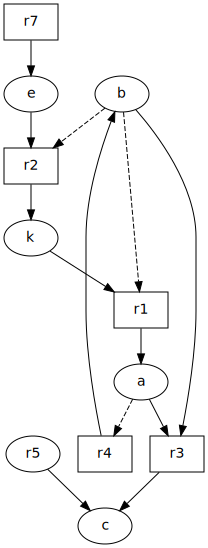

In [726]:
graphs[1]

In [727]:
bpdes = backwards_pde(adf, e.as_classical_atom())
for bpde in bpdes:
    print_bpde(bpde)

(e,{e},{},{},[r7,e])


1


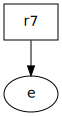

In [728]:
graphs = []
for bpde in bpdes:
    pde = (bpde.atom, bpde.facts, bpde.blocking, bpde.sequence)
    graph_prg = pde_to_clingraph_prg(adf, pde)
    graphs.append(draw_graph([graph_prg, COMMON])['default'])
print(len(graphs))
graphs[0]

In [729]:
a = ASPBasicLiteral.make_literal('a')
b = ASPBasicLiteral.make_literal('b')

r1 = ASPNormalRule(a, (b,))
r2 = ASPNormalRule(b, (a,))

rs = (r1, r2)

prg = make_program(*rs)
print(prg)

a :- b.
b :- a.


In [730]:
answer_sets = tuple(asp_evaluate(prg, report=True))

Answer 1: {  }
SAT 1


In [731]:
adf = asp_to_adf(*rs)
print(adf)

{r2 r1 b a} <a: r1, r1: b, b: r2, r2: a>


In [732]:
bpdes = backwards_pde(adf, a.as_classical_atom())
for bpde in bpdes:
    print_bpde(bpde)

(a,{},{},{b,a},[r2,b,r1,a])


1


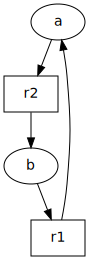

In [733]:
graphs = []
for bpde in bpdes:
    pde = (bpde.atom, bpde.facts, bpde.blocking, bpde.sequence)
    graph_prg = pde_to_clingraph_prg(adf, pde)
    graphs.append(draw_graph([graph_prg, COMMON])['default'])
print(len(graphs))
graphs[0]

In [734]:
a = ASPBasicLiteral.make_literal('a')
b = ASPBasicLiteral.make_literal('b')
c = ASPBasicLiteral.make_literal('c')

r1 = ASPNormalRule(a, (b,))
r2 = ASPNormalRule(b, (a,))
r3 = ASPNormalRule(b, (c,))
r4 = ASPNormalRule(c)

rs = (r1, r2, r3, r4)

prg = make_program(*rs)
print(prg)

a :- b.
b :- a.
b :- c.
c.


In [735]:
adf = asp_to_adf(*rs)
print(adf)

{r4 r1 c b r2 r3 a} <a: r1, r1: b, b: r2 ∨ r3, r2: a, r3: c, c: r4, r4: ⊤>


In [736]:
bpdes = backwards_pde(adf, a.as_classical_atom())
for bpde in bpdes:
    print_bpde(bpde)

(a,{},{},{b,a},[r2,b,r1,a])
(a,{c},{},{},[r4,c,r3,b,r1,a])


2


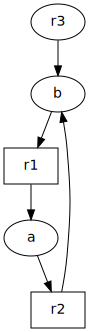

In [737]:
graphs = []
for bpde in bpdes:
    pde = (bpde.atom, bpde.facts, bpde.blocking, bpde.sequence)
    graph_prg = pde_to_clingraph_prg(adf, pde)
    graphs.append(draw_graph([graph_prg, COMMON])['default'])
print(len(graphs))
graphs[0]

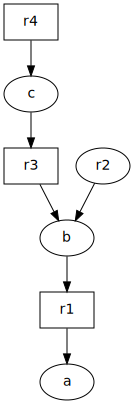

In [738]:
graphs[1]

In [739]:
bpdes = backwards_pde(adf, b.as_classical_atom())
for bpde in bpdes:
    print_bpde(bpde)

(b,{},{},{b,a},[r1,a,r2,b])
(b,{c},{},{},[r4,c,r3,b])


2


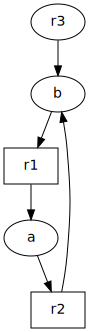

In [740]:
graphs = []
for bpde in bpdes:
    pde = (bpde.atom, bpde.facts, bpde.blocking, bpde.sequence)
    graph_prg = pde_to_clingraph_prg(adf, pde)
    graphs.append(draw_graph([graph_prg, COMMON])['default'])
print(len(graphs))
graphs[0]

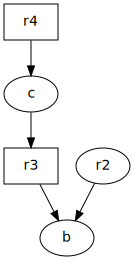

In [741]:
graphs[1]

In [742]:
bpdes = backwards_pde(adf, c.as_classical_atom())
for bpde in bpdes:
    print_bpde(bpde)

(c,{c},{},{},[r4,c])


1


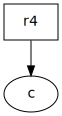

In [743]:
graphs = []
for bpde in bpdes:
    pde = (bpde.atom, bpde.facts, bpde.blocking, bpde.sequence)
    graph_prg = pde_to_clingraph_prg(adf, pde)
    graphs.append(draw_graph([graph_prg, COMMON])['default'])
print(len(graphs))
graphs[0]